# Generative Models

A generative model could be loosely defined as any model that takes an abstract, low dimensional input and outputs a high dimensional image as a result.  In this definition, the autoencoders we developed in the first tutorials count as generative networks.  But if you feed in random data, you are unlikely to get good output!

Generative Adversarial Networks create generative models through a different technique.  These networks take points from a random input distribution - say, N random values between 0 and 1.  They feed these values forward through the network, and the output of the network is an image that is - ideally - indistinguishable from the real images.

## Training a Generative Adversarial Network

You can build a generative model using an adversarial training technique.  This has been around for some time now, but the key components of the training process are this:
 - Two networks are created.  
     - One is a __generator__, which is tasked with taking random input (Let's say we give it a tensor of shape 50, with each value in the range (0, 1) ) and outputing an image (shape 28x28 as usual) which is indistinguishable from the handwritten digits in the mnist dataset.
     - The second network is a __discriminator__ or classifier which takes as input images and has to decide on a case-by-case basis which images are from the real dataset, and which images are from the __generator__.
 - During training, first the generator is run and it produces a set of output images.
 - Next, a set of *real* images is pulled from the dataset and augments the generated images.  Each image is given a label of 1 for fake, 0 for real.
 - The __discriminator__ runs and classifies the images as best it can, either real or fake.
 - The gradients of the __discriminator__ are updated easily, as it is just a classification problem.
 - The gradients of the __generator__ are then updated based on the success or failure of the discriminator.  In this way, the __generator__ is trained directly to trick the discriminator into believing the wrong images are real.
 
At the end of the training session, the discriminator network can usually be discarded while the generator remains as an interesting network.  You can use it moving forward to generate new fake data.

In [1]:
import tensorflow as tf
import numpy

from matplotlib import pyplot as plt
from IPython.display import display, clear_output

The network designs for a GAN need not be anything special. We will use very similar networks as before in our convolutional auto encoder, but the key difference will be how the networks are trained.  Let's start with our discriminator:

In [2]:
class Discriminator(tf.keras.models.Model):
    '''
    Simple classifier for mnist, but only 1 or 2 outputs:
        
    With 1 output, we will use a sigmoid cross entropy.
    
    '''
    
    def __init__(self, activation=tf.nn.tanh):
        tf.keras.models.Model.__init__(self)

        # Apply a 5x5 kernel to the image:
        self.discriminator_layer_1 = tf.keras.layers.Convolution2D(
            kernel_size = [5, 5], 
            filters     = 24,
            padding     = "same",
            activation  = activation,
        )
        
        self.dropout_1 = tf.keras.layers.Dropout(0.4)
        
        self.pool_1 = tf.keras.layers.MaxPool2D()
        
        self.discriminator_layer_2 = tf.keras.layers.Convolution2D(
            kernel_size = [5, 5], 
            filters     = 64, 
            padding     = "same",
            activation  = activation,
        )

        self.dropout_2 = tf.keras.layers.Dropout(0.4)
        
        self.pool_2 = tf.keras.layers.MaxPool2D()

        self.discriminator_layer_3 = tf.keras.layers.Convolution2D(
            kernel_size = [5, 5],
            filters     = 128,
            padding     = "same",
            activation  = activation,
        )
        
        self.dropout_3 = tf.keras.layers.Dropout(0.4)

        
        self.pool_3 = tf.keras.layers.MaxPool2D()

        self.discriminator_layer_final = tf.keras.layers.Dense(
            units = 1,
            activation = None,
            )
        
        
        


    def call(self, inputs):
        
        batch_size = inputs.shape[0]
        x = inputs
        # Make sure the input is the right shape:
        x = tf.reshape(x, [batch_size, 28, 28, 1])
            
        x = self.discriminator_layer_1(x)
        x = self.pool_1(x)
        x = self.dropout_1(x)
        x = self.discriminator_layer_2(x)
        x = self.pool_2(x)
        x = self.dropout_2(x)
        x = self.discriminator_layer_3(x)
        x = self.pool_3(x)
        x = self.dropout_3(x)
        x = tf.keras.layers.Flatten()(x)
        x = self.discriminator_layer_final(x)

        return x



And here is our generator model, which will expect as input some random-number fixed length tensor.

In [3]:
class Generator(tf.keras.models.Model):
    
    def __init__(self, activation=tf.nn.tanh):
        tf.keras.models.Model.__init__(self)

        # The first step is to take the random image and use a dense layer to 
        #make it the right shape
        
        self.dense = tf.keras.layers.Dense(
            units = 7 * 7 * 64
        )
        
        # This will get reshaped into a 7x7 image with 64 filters.
        
        # We need to upsample twice to get to a full 28x28 resolution image
        
        
        self.batch_norm_1 = tf.keras.layers.BatchNormalization()
        
        
        self.generator_layer_1 = tf.keras.layers.Convolution2D(
            kernel_size = [5, 5],
            filters     = 64,
            padding     = "same",
            use_bias    = True,
            kernel_regularizer = tf.keras.regularizers.L2(),
            activation  = activation,
        )
        
        self.unpool_1 = tf.keras.layers.UpSampling2D(
            size          = 2,
            interpolation = "nearest",
        )
        
        # After that unpooling the shape is [14, 14] with 64 filters
        self.batch_norm_2 = tf.keras.layers.BatchNormalization()


        self.generator_layer_2 = tf.keras.layers.Convolution2D(
            kernel_size = [5, 5],
            filters     = 32,
            padding     = "same",
            use_bias    = True,
            kernel_regularizer = tf.keras.regularizers.L2(),
            activation  = activation,
        )
        
        self.unpool_2 = tf.keras.layers.UpSampling2D(
            size          = 2,
            interpolation = "nearest",
        )

        self.batch_norm_3 = tf.keras.layers.BatchNormalization()


        self.generator_layer_3 = tf.keras.layers.Convolution2D(
            kernel_size = [5, 5],
            filters     = 8,
            padding     = "same",
            use_bias    = True,
            kernel_regularizer = tf.keras.regularizers.L2(),
            activation  = activation,
        )
        
        # Now it is [28, 28] by 24 filters, use a bottle neck to 
        # compress to a single image:
        self.batch_norm_4 = tf.keras.layers.BatchNormalization()


        self.generator_layer_final = tf.keras.layers.Convolution2D(
            kernel_size = [5, 5],
            filters     = 1,
            padding     = "same",
            use_bias    = True,
            kernel_regularizer = tf.keras.regularizers.L2(),
            activation  = tf.nn.sigmoid,
        )
        

        
    def call(self, inputs):
        ''' 
        Reshape at input and output: 
        '''
            
        
        batch_size = inputs.shape[0]


        x = self.dense(inputs)


        # First Step is to to un-pool the encoded state into the right shape:
        x = tf.reshape(x, [batch_size, 7, 7, 64])

        x = self.batch_norm_1(x)
        x = self.generator_layer_1(x)
        x = self.unpool_1(x)
        x = self.batch_norm_2(x)
        x = self.generator_layer_2(x)
        x = self.unpool_2(x)
        x = self.batch_norm_3(x)
        x = self.generator_layer_3(x)
        x = self.batch_norm_4(x)
        x = self.generator_layer_final(x)
        
        
        return x

Ok, let's run our networks forward and backwards to see the network parameters:


In [16]:
generator = Generator()


In [17]:
random_input = numpy.random.uniform(-1,1,[1,100]).astype(numpy.float32)
generated_image = generator(random_input)
generator.summary()


Model: "generator_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             multiple                  316736    
                                                                 
 batch_normalization_4 (Batc  multiple                 256       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           multiple                  102464    
                                                                 
 up_sampling2d_2 (UpSampling  multiple                 0         
 2D)                                                             
                                                                 
 batch_normalization_5 (Batc  multiple                 256       
 hNormalization)                                                 
                                                       

In [18]:
discriminator = Discriminator()
classification  = discriminator(generated_image)
discriminator.summary()

Model: "discriminator_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          multiple                  624       
                                                                 
 dropout_3 (Dropout)         multiple                  0         
                                                                 
 max_pooling2d_3 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          multiple                  38464     
                                                                 
 dropout_4 (Dropout)         multiple                  0         
                                                                 
 max_pooling2d_4 (MaxPooling  multiple                 0         
 2D)                                               

Let's again take a look at the output images before training:

0.36761037
0.68468434


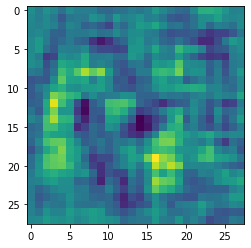

In [19]:
plt.imshow(generated_image.numpy().reshape([28,28]))
print(numpy.min(generated_image.numpy()))
print(numpy.max(generated_image.numpy()))

Just random noise!

## Helper functions for training

Training a GAN takes some care in bookkeeping since you are training two models simultaneously.  So let's lay out some functions to keep things neat and organized.

**Throughout, we're using 0 to  mean fake and 1 to mean real**


In [20]:
# Read in the mnist data so we have it loaded globally:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype(numpy.float32)
x_test  = x_test.astype(numpy.float32)

x_train /= 255.
x_test  /= 255.

In [21]:
print(numpy.min(x_train))
print(numpy.max(x_train))

0.0
1.0


In [22]:
def compute_loss(_logits, _targets):
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=_targets, logits=_logits)
    
    return tf.reduce_mean(loss)


In [23]:
def fetch_real_batch(_batch_size):
    indexes = numpy.random.choice(a=x_train.shape[0], size=[_batch_size,])
    
    images = x_train[indexes].reshape(_batch_size, 28, 28, 1)
    labels = y_train[indexes]
    
    return images, labels



In [24]:
def forward_pass(_generator, _discriminator, _batch_size, _input_size, _lie_rate):
        '''
        This function takes the two models and runs a forward pass to the computation of the loss functions
        '''

        # Fetch real data:
        real_data, _ = fetch_real_batch(_batch_size)
        
        
        
        # Use the generator to make fake images:
        random_noise = numpy.random.uniform(-1, 1, size=_batch_size*_input_size).astype(numpy.float32)
        random_noise = random_noise.reshape([_batch_size, _input_size])
        fake_images  = _generator(random_noise)
        

        # Use the discriminator to make a prediction on the REAL data:
        prediction_on_real_data = _discriminator(real_data)
        # Use the discriminator to make a prediction on the FAKE data:
        prediction_on_fake_data = _discriminator(fake_images)
        

        soften = 0.1
        real_labels = numpy.zeros([_batch_size,1], dtype=numpy.float32) + soften
        fake_labels = numpy.ones([_batch_size,1],  dtype=numpy.float32) - soften
        gen_labels  = numpy.zeros([_batch_size,1], dtype=numpy.float32)


        # Occasionally, we disrupt the discriminator (since it has an easier job)
        
        # Invert a few of the discriminator labels:
        
        n_swap = int(_batch_size * _lie_rate)
        
        real_labels [0:n_swap] = 1.
        fake_labels [0:n_swap] = 0.
        
        
        # Compute the loss for the discriminator on the real images:
        discriminator_real_loss = compute_loss(
            _logits  = prediction_on_real_data, 
            _targets = real_labels)
        
        # Compute the loss for the discriminator on the fakse images:
        discriminator_fake_loss = compute_loss(
            _logits  = prediction_on_fake_data, 
            _targets = fake_labels)

        # The generator loss is based on the output of the discriminator.
        # It wants the discriminator to pick the fake data as real
        generator_target_labels = [1] * _batch_size
        
        generator_loss = compute_loss(
            _logits  = prediction_on_fake_data, 
            _targets = real_labels)
        
        # Average the discriminator loss:
        discriminator_loss = 0.5*(discriminator_fake_loss  + discriminator_real_loss)
        
        # Calculate the predicted label (real or fake) to calculate the accuracy:
        predicted_real_label = numpy.argmax(prediction_on_real_data.numpy(), axis=-1)
        predicted_fake_label = numpy.argmax(prediction_on_fake_data.numpy(), axis=-1)

        discriminator_accuracy = 0.5 * numpy.mean(predicted_real_label == real_labels) + \
            0.5 * numpy.mean(predicted_fake_label == fake_labels)
        generator_accuracy = 0.5 * numpy.mean(predicted_fake_label == generator_target_labels)
          
        
        metrics = {
            "discriminator" : discriminator_accuracy,
            "generator"    : generator_accuracy
        }

        loss = {
            "discriminator" : discriminator_loss,
            "generator"    : generator_loss        
        }
        
        images = {
            "real" : real_data[0].reshape([28,28]),
            "fake" : fake_images.numpy()[0].reshape([28,28]) 
        }

        
        return loss, metrics, images

## Training Loop

In [25]:
# Here is a function that will manage the training loop for us:

def train_loop(batch_size, n_training_iterations, models, opts, lie_rate):



    # Create a plot that updates:
    fig = plt.figure(figsize=(16, 9))
    ax_loss = fig.add_subplot(131)
    ax_real = fig.add_subplot(132)
    ax_fake = fig.add_subplot(133)

    steps = []
    loss_history = {
        "generator" : [],
        "discriminator" : []
    }





    for i in range(n_training_iterations):

        for network in ["generator", "discriminator"]:

            with tf.GradientTape() as tape:
                    loss, metrics, images = forward_pass(
                        models["generator"],
                        models["discriminator"], 
                        _input_size = 100,
                        _batch_size = BATCH_SIZE,
                        _lie_rate   = lie_rate,
                    )


            if loss["discriminator"] < 0.01:
                break


            steps.append(i)
            loss_history["generator"].append(loss["generator"].numpy())
            loss_history["discriminator"].append(loss["discriminator"].numpy())


            trainable_vars = models[network].trainable_variables

            # Apply the update to the network:
            grads = tape.gradient(loss[network], trainable_vars)

            opts[network].apply_gradients(zip(grads, trainable_vars))


        if i % 25 == 0:
            # Update plots:
            ax_loss.cla()
            ax_loss.plot(steps, loss_history["generator"], label="Generator Loss")
            ax_loss.plot(steps, loss_history["discriminator"], label="Discriminator Loss")
            ax_loss.grid(True)
            ax_loss.legend()
            ax_real.imshow(images['real'],vmin=0, vmax=1)
            ax_real.set_title("Real", fontsize=20)
            ax_fake.imshow(images['fake'],vmin=0, vmax=1)
            ax_fake.set_title("Fake", fontsize=20)
            display(fig)
            clear_output(wait = True)
            plt.pause(0.25)




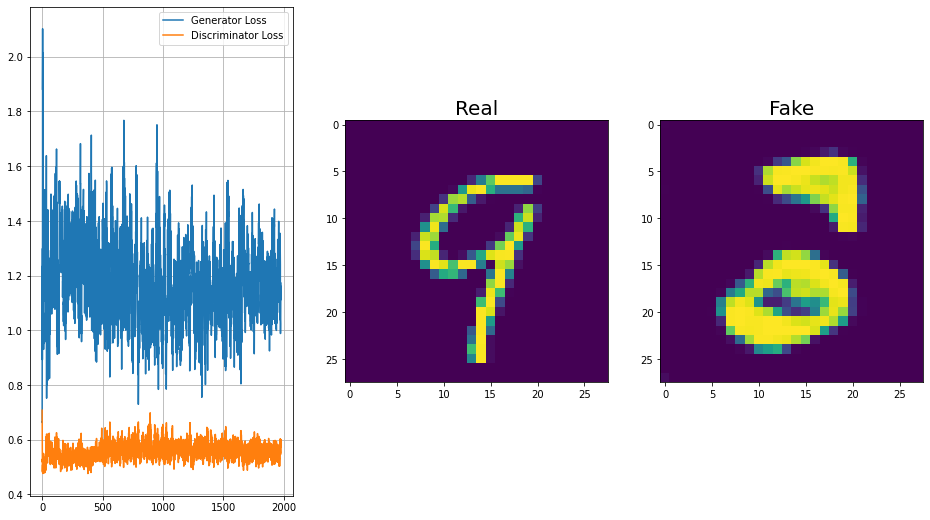

In [26]:
BATCH_SIZE=64
N_TRAINING_ITERATIONS = 2000


models = {
    "generator" : generator,
    "discriminator" : discriminator  
}

opts = {
    "generator" : tf.keras.optimizers.Adam(),
    "discriminator" : tf.keras.optimizers.Adam()


}

train_loop(BATCH_SIZE, N_TRAINING_ITERATIONS, models, opts, lie_rate=0.1)

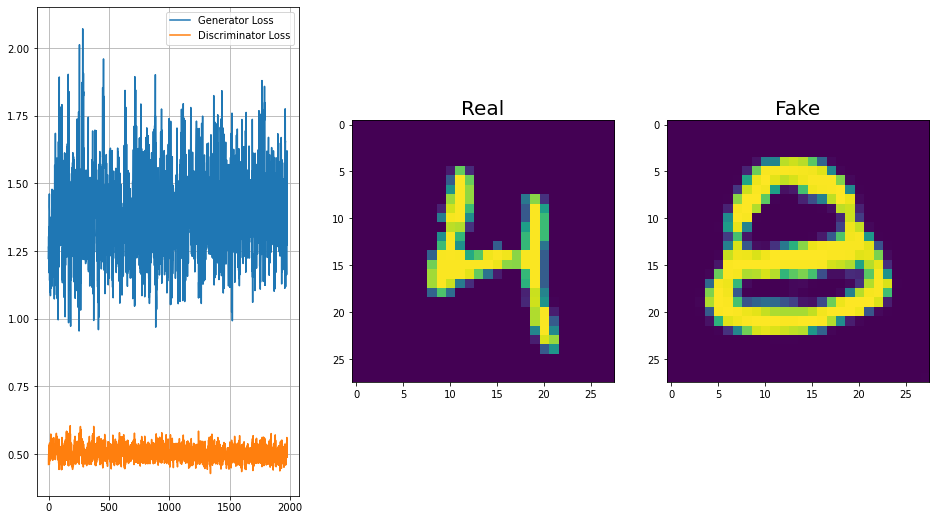

In [27]:
train_loop(BATCH_SIZE, N_TRAINING_ITERATIONS, models, opts, lie_rate=0.05)

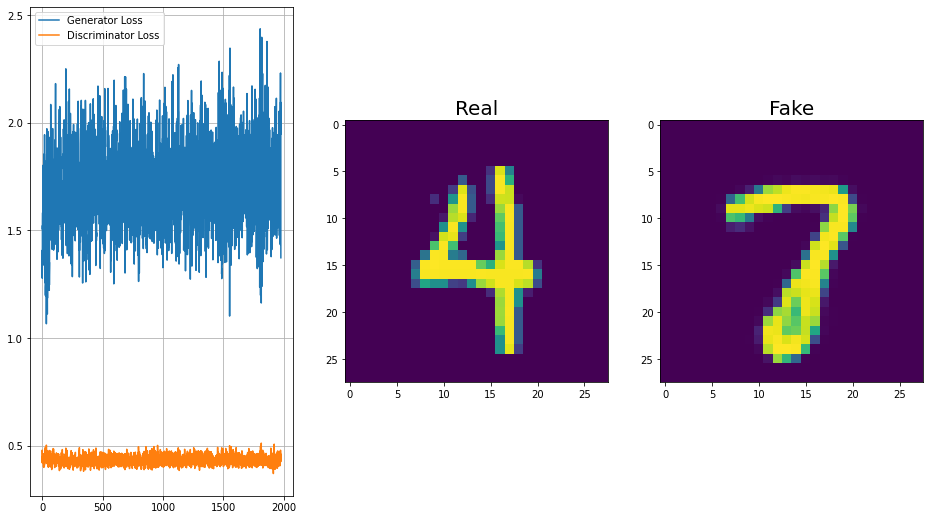

In [28]:
train_loop(BATCH_SIZE, N_TRAINING_ITERATIONS, models, opts, lie_rate=0.01)

Getting a GAN to train successfully, even on MNIST, is no small challenge.   The previous cells will train a network for 2000 steps initally, and more as you choose to run it, and hopefully it eventually converges for you.  But there are a number of minor changes that will cause training to completely collapse:
 - Try using a different activation function (like relu, leaky_relu, sigmoid) - does it train?
 - Try not confusing the discriminator with label swapping.  Can it train?
 - Try turning off the label smoothing - still training?

Running the training for a GAN is a pretty long process, even for mnist.  So there are included here pretrained weights you can use, for the remainder of this notebook, if your model didn't train well.

In [35]:
generator.save_weights("generator.h5")
discriminator.save_weights("discriminator.h5")

# Exploring the abilities of the GAN network

At this point, the GAN is reasonably trained.  We ran for 6000 iterations, which is only a handful of epochs, but the output digits are looking somewhat reasonable.  Let's explore how the GAN is working.

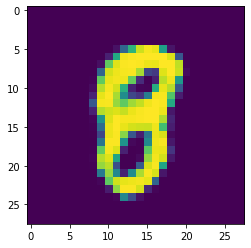

In [29]:
# What happens when all 0s go in?
zeros = numpy.zeros([1,100]).astype(numpy.float32)
zero_input_image = generator(zeros)
plt.imshow(zero_input_image.numpy().reshape(28,28))

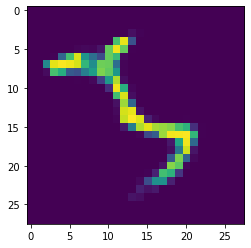

In [30]:
# What happens when all 1's go in?
ones = numpy.ones([1,100]).astype(numpy.float32)
ones_input_image = generator(ones)
plt.imshow(ones_input_image.numpy().reshape(28,28))

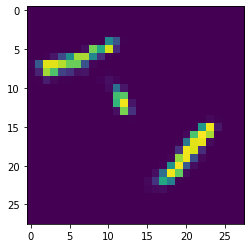

In [31]:
# What happens when all 2's go in?
twos = 2*numpy.ones([1,100]).astype(numpy.float32)
twos_input_image = generator(twos)
plt.imshow(twos_input_image.numpy().reshape(28,28))

Let's vary the input more smoothly between two points.  We'll draw them randomly:

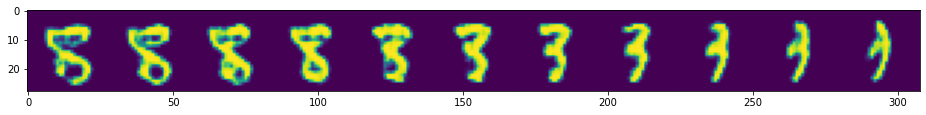

In [34]:
initial_point = numpy.random.uniform(-1,1,[1,100]).astype(numpy.float32)
final_point   = numpy.random.uniform(-1,1,[1,100]).astype(numpy.float32)

N_STEPS = 10

output_image = numpy.zeros([28, (N_STEPS+1)*28])


for i in range(N_STEPS + 1):
    step = 1 - (N_STEPS - i )/ N_STEPS
    input_point = initial_point + step * (final_point - initial_point) 
    this_image = generator(input_point).numpy().reshape(28,28)
    output_image[:, i*28:(i+1)*28] = this_image

fig = plt.figure(figsize=(16,4))
plt.imshow(output_image)

Try running this more, or using your own ideas for input, to see how the generator is smoothly transforming one digit into another.

# Follow up Investigations for GANs

GANs are tricky to train and can fall into all sorts of pitfalls.  The one show here works but at the same time, it's easy to make minor tweaks and see that it no longer trains.

Do you want to learn more about GANs?  Here are some things you could explore doing with the basis from this notebook:

1) Try changing some of the parameters of the network:
 - Input Size and distribution
 - Activation function
 - Dropout rates
 - What else can you change?
 
2) Try changing how it is being trained:
 - Train both generator and discriminator simultaneously
 - Try different optimizers and learning rates
 - Instead of doing label swaps, try adding random noise to the real and fake images to make the classification harder.  
 - Can you turn down the label swapping as training progresses?
 
3) Can you do more complicated GANs?  What about a network that turns every 7 into 1 one and vice-versa?  You will need a discriminator to train the generator, but also a classifier to train the generator.  How do you balance the loss?
 
4) You could work on more datasets as well.  There is fashion MNIST, CIFAR, or explore a science domain dataset.
 